In [1]:
import time
from itertools import product
import numpy as np
from scipy.stats import poisson, skellam
import matplotlib.pyplot as plt

maxNumCounted = 28
creditRate = 10
transfer_cost = 2
expectedRent1 = 3
expectedReturn1 = 3
expectedRent2 = 4
expectedReturn2 = 2
maxCarsAvail = 20
maxCarsTransferred = 5
states_num = (maxCarsAvail+1)*(maxCarsAvail+1)

In [2]:
def iterateInplace(value, getStatesIter, getActionsIter, getStateTransitionsIter, 
                 gamma=1.0, max_iter=None, Theta=np.finfo(np.float32).resolution):
    it = 1
    new_value = value
    while True:
        delta = 0.0
        print("Iteration {}".format(it), end="", flush=True)
        for state in getStatesIter():
            print(str(state)+"\r", end="", flush=True)
            v = value[state]
            qsa = [np.sum([prob*(reward + gamma*value[next_state])
                           for next_state, prob, reward 
                           in getStateTransitionsIter(state,action)]
                         )
                   for action in getActionsIter(state)]
            new_value[state] = max(qsa)
            delta = max(delta, abs(v-new_value[state]))
        print("[Done] delta={}".format(delta))
        if max_iter and it >= max_iter or delta < Theta: break
        it += 1
    return new_value

In [3]:
def evalDetermPolicy(value, policy, getStatesIter, getStateTransitionsIter, gamma, max_iter=None, Theta=1.0e-5):
    it = 1
    startTime = time.time()
    while True:
        lap_time = time.time()
        delta = 0
        print("Iteration {}  ".format(it), end="", flush=True)
        for step,state in enumerate(getStatesIter()):
            v = value[state]
            action = policy[state]
            value[state] = np.sum([prob*(reward + gamma*value[next_state])
                           for next_state, prob, reward 
                           in getStateTransitionsIter(state,action)])
            delta = max(delta, abs(v-value[state]))
            if time.time()-lap_time >= 10:
                print("\rIteration {}; Progress {:4.1f}%".format(it, float(step)/states_num*100), 
                      end="", flush=True)
                lap_time = time.time()        
        print("\n[Done] delta={}".format(delta))
        if max_iter and it >= max_iter or delta < Theta: break
        it += 1
    return value

def evalDetermPolicy_2(value, policy, getStatesIter, getStateTransitionsDist, gamma, max_iter=None, Theta=1.0e-5):
    it = 1
    startTime = time.time()
    while True:
        lap_time = time.time()
        delta = 0
        print("Iteration {}  ".format(it), end="", flush=True)
        for step, state in enumerate(getStatesIter()):
            action = policy[state]
            sum_reward, dist = getStateTransitionsDist(state,action)
            v = sum_reward + gamma*np.tensordot(dist,value)
            delta = max(delta, abs(v-value[state]))
            value[state] = v
            if time.time()-lap_time >= 10:
                print("\rIteration {}; Progress {:4.1f}%".format(it, float(step)/states_num*100), 
                      end="", flush=True)
                lap_time = time.time()
        print("\n[Done] in {:5.4} sec; delta={}".format(time.time()-startTime, delta))
        if max_iter and it >= max_iter or delta < Theta: break
        it += 1
    return value

def improvePolicy_2(value, policy, getStatesIter, getActionsIter, 
                  getStateTransitionsDist, gamma):
    policy_stable = True
    startTime = time.time()
    lap_time = startTime
    print("Improving policy.", end="", flush=True)
    for step,state in enumerate(getStatesIter()):
        old_action = policy[state]
        max_qsa = np.finfo(np.float32).min
        for action in getActionsIter(state):
            sum_reward, dist = getStateTransitionsDist(state,action)
            qsa = sum_reward + gamma*np.tensordot(dist,value)

            if qsa > max_qsa:
                max_qsa = qsa
                max_action = action

        policy[state] = max_action
        policy_stable = policy_stable and max_action == old_action
        if time.time()-lap_time >= 10:
            print("\rImproving policy. Progress {:4.1f}%".format(float(step)/states_num*100), 
                  end="", flush=True)
            lap_time = time.time()
        
    print("\n[Done in {:5.4} sec]".format(time.time()-startTime))
    return policy_stable

In [4]:
def improvePolicy(value, policy, getStatesIter, getActionsIter, 
                  getStateTransitionsSummary, gamma):
    policy_stable = True
    startTime = time.time()
    lap_time = startTime
    print("Improving policy ", end="", flush=True)
    for step,state in enumerate(getStatesIter()):
        old_action = policy[state]
        max_qsa = np.finfo(np.float32).min
        for action in getActionsIter(state):
            qsa = np.sum([w_reward + prob_sum*gamma*value[next_state]
                           for next_state, prob_sum, w_reward
                           in getStateTransitionsSummary(state,action)])

            if qsa > max_qsa:
                max_qsa = qsa
                max_action = action

        policy[state] = max_action
        policy_stable = policy_stable and max_action == old_action
        if time.time()-lap_time >= 10:
            print("\rImproving policy. Progress {:4.1f}%".format(float(step)/states_num*100), 
                  end="", flush=True)
            lap_time = time.time()
        
    print("\n[Done in {:5.4} sec]".format(time.time()-startTime))
    return policy_stable

In [5]:
poissonCache = np.array([[poisson.pmf(x,expect)
                          for x in range(maxNumCounted+1)]
                         for expect in range(expectedReturn2,expectedRent2+1)],
                        dtype=np.float64)

def getPoisson(n,e):
    return poissonCache[e-expectedReturn2, n]

returned_prob = np.array([[getPoisson(returned1, expectedReturn1) * 
                        getPoisson(returned2, expectedReturn2)
                        for returned2 in range(maxNumCounted+1)] 
                        for returned1 in range(maxNumCounted+1)],
                        dtype=np.float64)
rented_prob = np.array([[getPoisson(rented1, expectedRent1) * 
                        getPoisson(rented2, expectedRent2)
                        for rented2 in range(maxNumCounted+1)]
                        for rented1 in range(maxNumCounted+1)],
                      dtype=np.float64)

def getJacksCarTransitions(cars_left, transfer):
    cars1, cars2 = cars_left
    if cars1 < transfer or cars2 < -transfer:
        return
    cars_avail_1 = cars1-transfer
    cars_avail_2 = cars2+transfer
    
    for returned1,returned2 in product(range(maxNumCounted+1), range(maxNumCounted+1)):
        c1 = min(cars_avail_1+returned1, maxCarsAvail)
        c2 = min(cars_avail_2+returned2, maxCarsAvail)
        for rented1,rented2 in product(range(maxNumCounted+1), range(maxNumCounted+1)):
            left_1 = max(0,c1-rented1)
            left_2 = max(0,c2-rented2)
            yield ((max(0,c1-rented1), max(0,c2-rented2)),
                returned_prob[returned1,returned2] * rented_prob[rented1,rented2],
                creditRate*(c1+c2 - (left_1+left_2)) - transfer_cost*abs(transfer)
                  )

getActionsIter = \
    lambda s: range(max(-s[1],-maxCarsTransferred), min(s[0],maxCarsTransferred)+1)


In [152]:
#l = [p for s,p,r in getJacksCarTransitions((1,1),0)]
l = [p for p in cache_3((5,9),2)[1]]
len(l), np.sum(l)

(21, 0.9999999999999991)

In [20]:
value = np.zeros((maxCarsAvail+1,maxCarsAvail+1), dtype=np.float64)
policy = np.zeros((maxCarsAvail+1,maxCarsAvail+1), dtype=np.int8)

In [ ]:
v = evalDetermPolicy_2(value,
               policy,
               lambda : product(range(maxCarsAvail+1),range(maxCarsAvail+1)),
               getCachedDist, #getJacksCarTransitionsDist, #cache_3, #getJacksCarTransitionsDist, 
               gamma=0.9,
               max_iter=15,
               Theta=0.01
              )

In [43]:
v = evalDetermPolicy(value,
               policy,
               lambda : product(range(maxCarsAvail+1),range(maxCarsAvail+1)),
               getJacksCarTransitions_3, 
               gamma=0.9,
               max_iter=1,
               Theta=0.1
              )

Iteration 1; Progress 86.5%
[Done] delta=215.51885571937407


### Compete Policy Iteration

In [ ]:
value = np.zeros((maxCarsAvail+1,maxCarsAvail+1), dtype=np.float64)
policy = np.zeros((maxCarsAvail+1,maxCarsAvail+1), dtype=np.int8)
policy_iterations = []

while True:
    v = evalDetermPolicy_2(
               value,
               policy,
               lambda : product(range(maxCarsAvail+1),range(maxCarsAvail+1)),
               getCachedDist, #getJacksCarTransitionsDist, #cache_3, #getJacksCarTransitionsDist, 
               gamma=0.9,
               max_iter=15,
               Theta=0.01
              )
    policy_iterations.append(policy.copy())
    
    if improvePolicy_2(
              value,
              policy,
              lambda : product(range(maxCarsAvail+1),range(maxCarsAvail+1)),
              getActionsIter,
              getCachedDist, #getJacksCarTransitionsDist, #cache_3,
              gamma=0.9
              ):
        break

### Draw the value function

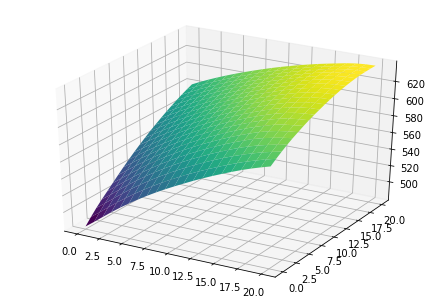

In [73]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(0, 21, 1)
Y = np.arange(0, 21, 1)
X, Y = np.meshgrid(X, Y)

it = zip(X.ravel(), Y.ravel())

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, v, rstride=1, cstride=1, cmap=cm.viridis)

plt.show()

In [74]:
np.min(value), np.max(value)

(480.60886190087746, 639.9782085667744)

In [112]:
"Is policy stable? - {}".format \
(improvePolicy_2(value,
              policy,
              lambda : product(range(maxCarsAvail+1),range(maxCarsAvail+1)),
              getActionsIter,
              getJacksCarTransitionsDist, #cache_3,
              gamma=0.9
              ))

Improving policy. Progress 96.4%
[Done in 20.87 sec]


'Is policy stable? - True'

In [82]:
improvePolicy(value,
              policy,
              lambda : product(range(maxCarsAvail+1), repeat=2),
              getActionsIter,
              getJacksCarTransitions_3,
              gamma=0.9
              )

Improving policy. Progress 95.5%
[Done in 143.9 sec]


False

In [6]:
def getJacksCarTransitions_2(cars_left, transfer):
    cars1, cars2 = cars_left
    if cars1 < transfer or cars2 < -transfer:
        return
    cars_avail_1 = cars1-transfer
    cars_avail_2 = cars2+transfer
    
    for returned1 in range(maxCarsAvail-cars_avail_1+1):
        ret1_prob = getPoisson(returned1,expectedReturn1)
        if returned1 == maxCarsAvail-cars_avail_1:
            ret1_prob += np.sum([getPoisson(r1,expectedReturn1) 
                                 for r1 in range(returned1+1, maxNumCounted+1)])
            
        for returned2 in range(maxCarsAvail-cars_avail_2+1):
            ret2_prob = getPoisson(returned2,expectedReturn2)
            if returned2 == maxCarsAvail-cars_avail_2:
                ret2_prob += np.sum([getPoisson(r2,expectedReturn2) 
                                     for r2 in range(returned2+1, maxNumCounted+1)])

            c1 = cars_avail_1+returned1
            c2 = cars_avail_2+returned2
            for rented1,rented2 in product(range(maxNumCounted+1), range(maxNumCounted+1)):
                left_1 = max(0,c1-rented1)
                left_2 = max(0,c2-rented2)
                yield ((max(0,c1-rented1), max(0,c2-rented2)),
                    ret1_prob * ret2_prob * rented_prob[rented1,rented2],
                    creditRate*(c1+c2 - (left_1+left_2)) - transfer_cost*abs(transfer)
                      )

In [7]:
def getJacksCarTransitions_3(cars_left, transfer):
    cars1, cars2 = cars_left
    if cars1 < transfer or cars2 < -transfer:
        return
    cars_avail_1 = cars1-transfer
    cars_avail_2 = cars2+transfer
    
    for returned1 in range(maxCarsAvail-cars_avail_1+1):
        ret1_prob = getPoisson(returned1,expectedReturn1)
        if returned1 == maxCarsAvail-cars_avail_1:
            ret1_prob += np.sum([getPoisson(r1,expectedReturn1) 
                                 for r1 in range(returned1+1, maxNumCounted+1)])
            
        for returned2 in range(maxCarsAvail-cars_avail_2+1):
            ret2_prob = getPoisson(returned2,expectedReturn2)
            if returned2 == maxCarsAvail-cars_avail_2:
                ret2_prob += np.sum([getPoisson(r2,expectedReturn2)
                                     for r2 in range(returned2+1, maxNumCounted+1)])

            c1 = cars_avail_1+returned1
            c2 = cars_avail_2+returned2
            for rented1 in range(c1+1):
                rent1_prob = getPoisson(rented1, expectedRent1)
                if (rented1 == c1):
                    rent1_prob += np.sum([getPoisson(r1,expectedRent1)
                                 for r1 in range(rented1+1, maxNumCounted+1)])
                    
                for rented2 in range(c2+1):
                    rent2_prob = getPoisson(rented2, expectedRent2)
                    if (rented2 == c2):
                        rent2_prob += np.sum([getPoisson(r2,expectedRent2)
                                     for r2 in range(rented2+1, maxNumCounted+1)])
                    
                    left_1 = c1-rented1
                    left_2 = c2-rented2
                    yield ((left_1, left_2),
                        ret1_prob * ret2_prob * rent1_prob * rent2_prob,
                        creditRate*(rented1+rented2) - transfer_cost*abs(transfer)
                          )

In [8]:
def compileDistribution(state, action, getStateTransitionsIter):
    dist = np.zeros(shape=(maxCarsAvail+1,maxCarsAvail+1), dtype=np.float64)
    summary_reward = np.float64(0)
    for next_state, prob, reward in getStateTransitionsIter(state,action):
        dist[next_state] += prob
        summary_reward += prob*reward
        
    # normalize weighted reward by probability of next state
    #for s in summary:
    #    s[1] /= s[0]
        
    return (summary_reward, dist)

class getJacksCarCachedTransitionsSummary:
    
    def __init__(self, getStateTransitionsIter):
        self.store = {}
        self.get_trans = getStateTransitionsIter

    def __call__(self, state, action):
        key = state,action
        if not key in self.store:
            summary_dist = compileDistribution(state, action, self.get_trans)
            self.store[key] = summary_dist
        else:
            summary_dist = self.store[key]
        
        return summary_dist

cache_3 = getJacksCarCachedTransitionsSummary(getJacksCarTransitions_3)
cache = getJacksCarCachedTransitionsSummary(getJacksCarTransitions)

### Try Value iteration

In [44]:
value_3 = np.zeros((maxCarsAvail+1,maxCarsAvail+1), dtype=np.float64)

In [ ]:
v = iterateInplace(value_3,
               lambda : product(range(maxCarsAvail+1), repeat=2),
               getActionsIter,
               getJacksCarTransitions_3,
               gamma=0.9,
               max_iter=4
              )

### Draw the policy

In [105]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

x = np.arange(0, maxCarsAvail+1)
y = np.arange(0, maxCarsAvail+1)
X, Y = np.meshgrid(x, y)

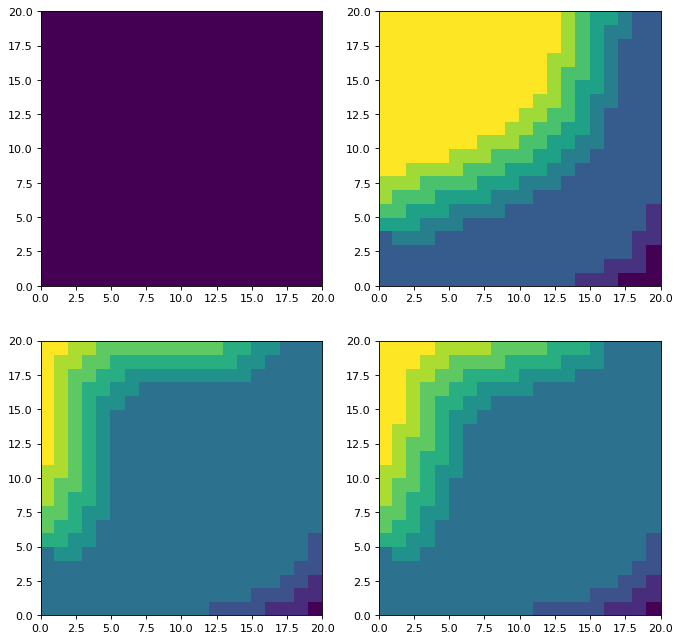

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), dpi=80)
tile = product(range(2),range(2))
for pol in policy_iterations:
    axes[next(tile)].pcolor(X, Y, pol)

### More sophisticated implementation

In [66]:
poissonCache_2 = np.array([[(poisson.pmf(x,expect), poisson.sf(x-1,expect))
                          for x in range(maxNumCounted+1)]
                         for expect in range(expectedReturn2,expectedRent2+1)],
                       dtype=np.float64)

def getJacksCarProbAndReward(available, transition, remained, expectedRent, expectedReturn):
    # remained = available - (rented + transition) + returned 
    # rented = (available  + returned) - (remained + transition)
    # available_before_rent = remained+rented = available-transition+returned <= maxCarsAvail
    # rented <= maxCarsAvail-remained
    # available-(remained+transition) <= rented <= maxCarsAvail-remained
    # returned = remained - available + rented + transition
    # 0 <= returned
    if transition > available: return [(0.0, 0)]
    expectedReturn -= expectedReturn2
    expectedRent -= expectedReturn2
    is_rented_out = remained==0
    max_returned_left = maxCarsAvail-available+transition

    dist = []
    for returned in range(max_returned_left+1):
        rented = (available  + returned) - (remained + transition)
        rentProb = poissonCache_2[expectedRent, rented, int(is_rented_out)]
        is_max_returned = returned == max_returned_left
        returnedProb = poissonCache_2[expectedReturn, returned, int(is_max_returned)]
        dist.append((rentProb*returnedProb, rented*creditRate))
    
    return dist

def getJacksCarProbDist_2(available, transition, expectedRent, expectedReturn):
    dist = np.zeros(shape=(maxCarsAvail+1,2), dtype=np.float64)
    if transition > available:
        return dist
    
    for remained in range(maxCarsAvail+1):
        dist[remained] = np.sum([(p,p*r) 
            for p,r in getJacksCarProbAndReward(available, transition, remained,
                                                expectedRent, expectedReturn)],
                                axis=0)
    
    return dist

In [53]:
def getJacksCarProbDist(available, transition, expectedRent, expectedReturn):
    dist = np.zeros(shape=(maxCarsAvail+1,2), dtype=np.float64)
    if transition > available:
        return dist

    for requested_for_rent,returned in product(range(maxNumCounted+1), repeat=2):
        available_for_rent = min(available-transition+returned, maxCarsAvail)
        actually_rented = min(available_for_rent, requested_for_rent)
        remained = available_for_rent - actually_rented
        
        prob = getPoisson(requested_for_rent, expectedRent) * \
                           getPoisson(returned, expectedReturn)
        dist[remained] += [prob, prob * actually_rented * creditRate]

    return dist

In [71]:
getDistribution = getJacksCarProbDist_2 #getJacksCarProbDist #getJacksCarProbDist_2

jacks_car_distribution_1 = \
    [dict([(t,getDistribution(cars_left, t, expectedRent1, expectedReturn1)) 
     for t in range(-maxCarsTransferred, min(cars_left,maxCarsTransferred)+1)]) 
    for cars_left in range(maxCarsAvail+1)]

jacks_car_distribution_2 = \
    [dict([(t,getDistribution(cars_left, t, expectedRent2, expectedReturn2)) 
     for t in range(-maxCarsTransferred, min(cars_left,maxCarsTransferred)+1)]) 
    for cars_left in range(maxCarsAvail+1)]

zero_dist = (0.0, np.zeros(shape=(maxCarsAvail+1,maxCarsAvail+1,2)))

def getCachedDist(cars_left,transfer):
    dict_1 = jacks_car_distribution_1[cars_left[0]]
    if not transfer in dict_1:
        return zero_dist
    p_wr_1 = dict_1[transfer]
    dict_2 = jacks_car_distribution_2[cars_left[1]]
    if not -transfer in dict_2:
        return zero_dist
    p_wr_2 = dict_2[-transfer]
    w_reward = np.sum(p_wr_1[:,1]) + np.sum(p_wr_2[:,1]) - transfer_cost*abs(transfer)
    return (w_reward, 
        np.matmul(np.array([p_wr_1[:,0]]).transpose(), np.array([p_wr_2[:,0]]))
           )
    

In [16]:
def getJacksCarTransitionsDist(cars_left, transfer):
    p_wr_1 = getJacksCarProbDist(cars_left[0], transfer, expectedRent1, expectedReturn1)
    p_wr_2 = getJacksCarProbDist(cars_left[1], -transfer, expectedRent2, expectedReturn2)
    w_reward = np.sum(p_wr_1[:,1]) + np.sum(p_wr_2[:,1]) - transfer_cost*abs(transfer)
    return (w_reward, 
        np.matmul(np.array([p_wr_1[:,0]]).transpose(), np.array([p_wr_2[:,0]]))
           )
        

### Testing and debugging

In [ ]:
test_action = 2
test_state = (3,19)
gamma = 0.9

getCachedDist(test_state,test_action)[1][4], getJacksCarTransitionsDist(test_state,test_action)[1][4]

In [161]:
test_action = 4
test_state = (9,8)


p1 = np.sum(np.array([prob for next_state, prob, reward 
                           in getJacksCarTransitions(test_state,test_action)],
                    dtype = np.float64)
           )

p3 = np.sum(np.array([prob for next_state, prob, reward 
                           in getJacksCarTransitions_3(test_state,test_action)],
                    dtype = np.float64)
           )

p1,p3

(0.9999999999999994, 0.9999999999999994)

In [76]:
test_action = 1
test_state = (4,8)

(getJacksCarProbDist_2(test_state[0], test_action, expectedRent1, expectedReturn1)[10:],
 getJacksCarProbDist(test_state[0], test_action, expectedRent1, expectedReturn1)[10:])

(array([[ 3.11558835e-03,  3.14528421e-02],
        [ 1.04842807e-03,  9.59340601e-03],
        [ 3.19780208e-04,  2.67262659e-03],
        [ 8.90876053e-05,  6.84653549e-04],
        [ 2.28221423e-05,  1.62209080e-04],
        [ 5.40928516e-06,  3.55785268e-05],
        [ 1.20020316e-06,  6.28869168e-06],
        [ 2.92701703e-07, -4.94523910e-06],
        [ 2.92497076e-07, -3.51029810e-05],
        [ 1.19967118e-06, -1.83227290e-04],
        [ 5.40869124e-06, -8.83554147e-04]]),
 array([[3.11558835e-03, 3.14528421e-02],
        [1.04842807e-03, 9.59340606e-03],
        [3.19780202e-04, 2.67262705e-03],
        [8.90875684e-05, 6.84657083e-04],
        [2.28219028e-05, 1.62234324e-04],
        [5.40781079e-06, 3.57482644e-05],
        [1.19160881e-06, 7.36172507e-06],
        [2.45390836e-07, 1.42045197e-06],
        [4.73483992e-08, 2.49994601e-07],
        [8.33315338e-09, 3.23334814e-08],
        [1.07778271e-09, 0.00000000e+00]]))

In [58]:
test_action = -2
test_state = (13,12)
next_state = (14,11)

gamma = 0.9

d1 = getJacksCarProbAndReward(test_state[0], test_action, next_state[0], 
                                  expectedRent1, expectedReturn1)
(np.sum([p for p,r in d1]), 
 getJacksCarProbDist(test_state[0], test_action, expectedRent1, expectedReturn1
                    )[next_state[0]][0])

(0.1549933833264024, 0.1549933833264024)